In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# ===============================
# 1. Cargar datos
# ===============================
df = pd.read_csv("usuarios_win_mac_lin.csv")

X = df[["duracion", "paginas", "acciones", "valor"]].values
y = df["clase"].values   # 0=Windows, 1=Macintosh, 2=Linux

# Escalamos los datos para mejorar la convergencia
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df.head()

,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2


In [ ]:
# ===============================
# 2. Funciones auxiliares
# ===============================
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

In [ ]:
def logistic_regression_multiclass(X, y, lr=0.1, epochs=1000, num_classes=3):
    m, n = X.shape
    W = np.zeros((n, num_classes))  # pesos
    b = np.zeros((1, num_classes))  # bias

    Y = one_hot(y, num_classes)

    losses = []
    for epoch in range(epochs):
        # Forward
        Z = X.dot(W) + b
        A = softmax(Z)

        # Cálculo de pérdida (log-loss)
        loss = -np.mean(np.sum(Y * np.log(A + 1e-9), axis=1))
        losses.append(loss)

        # Gradientes
        dW = (1/m) * X.T.dot(A - Y)
        db = (1/m) * np.sum(A - Y, axis=0, keepdims=True)

        # Actualización
        W -= lr * dW
        b -= lr * db

        if epoch % 200 == 0:
            print(f"Iter {epoch}, loss={loss:.4f}")

    return W, b, losses

# Entrenar modelo
W, b, losses = logistic_regression_multiclass(X_train, y_train, lr=0.5, epochs=2000)

Iter 0, loss=1.0986
Iter 200, loss=0.6782
Iter 400, loss=0.6418
Iter 600, loss=0.6203
Iter 800, loss=0.6048
Iter 1000, loss=0.5928
Iter 1200, loss=0.5831
Iter 1400, loss=0.5752
Iter 1600, loss=0.5685
Iter 1800, loss=0.5627


In [ ]:
# ===============================
# 4. Predicciones
# ===============================
def predict(X, W, b):
    Z = X.dot(W) + b
    A = softmax(Z)
    return np.argmax(A, axis=1)

y_pred = predict(X_test, W, b)

In [ ]:
print("Accuracy en test:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

Accuracy en test: 0.6470588235294118
Matriz de confusión:
 [[12  2  2]
 [ 8  4  0]
 [ 0  0  6]]


In [ ]:
# 1) Graficar curva de pérdida (descenso por gradiente)
fig1, ax1 = plt.subplots()
ax1.plot(range(len(losses)), losses)
ax1.set_xlabel("Iteraciones")
ax1.set_ylabel("Loss (entropía cruzada)")
ax1.set_title("Curva de pérdida durante el descenso por gradiente")
loss_curve_path = "/content/graficas/loss_curve_multiclass.png"
fig1.savefig(loss_curve_path, bbox_inches="tight")

# 2) Graficar matriz de confusión como mapa de calor
cm = confusion_matrix(y_test, y_pred)
fig2, ax2 = plt.subplots()
cax = ax2.matshow(cm, cmap="Blues")
fig2.colorbar(cax)
for (i, j), val in np.ndenumerate(cm):
    ax2.text(j, i, f"{val}", ha='center', va='center')
ax2.set_xlabel("Predicción")
ax2.set_ylabel("Real")
ax2.set_title("Matriz de confusión")
conf_matrix_path = "/content/graficas/confusion_matrix.png"
fig2.savefig(conf_matrix_path, bbox_inches="tight")

plt.close("all")

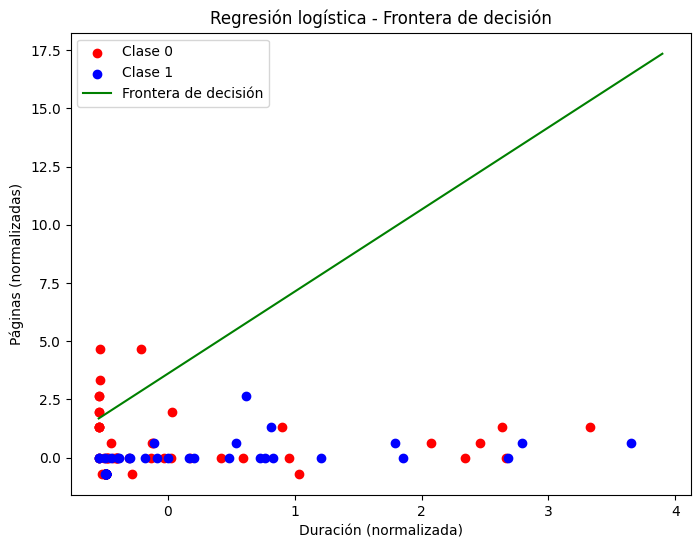

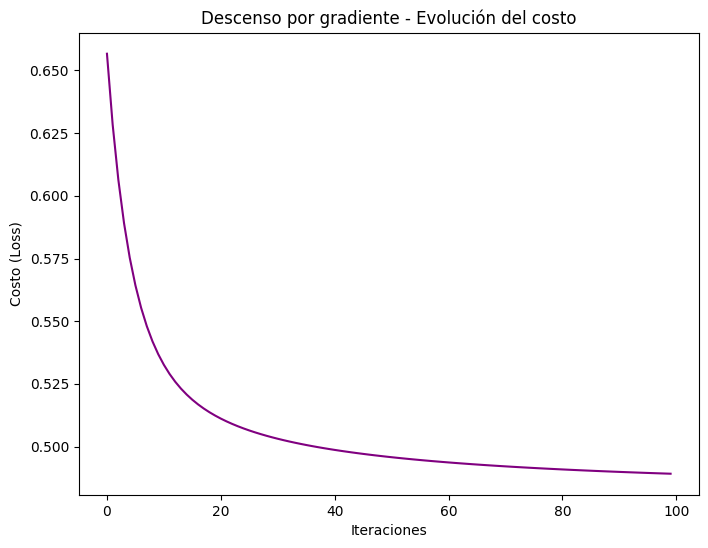

In [9]:
# Reimportar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Codificar la variable categórica "clase"
encoder = LabelEncoder()
df["clase"] = encoder.fit_transform(df["clase"])

# Variables predictoras (dos columnas para visualizar en 2D)
X = df[["duracion", "paginas"]].values
y = df["clase"].values

# Normalización
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Funciones de regresión logística
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    return -(1/m) * np.sum(y*np.log(h+1e-8) + (1-y)*np.log(1-h+1e-8))

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = []
    for _ in range(iterations):
        h = sigmoid(X @ theta)
        theta -= alpha * (1/m) * (X.T @ (h - y))
        cost_history.append(compute_cost(X, y, theta))
    return theta, cost_history

# Agregar columna de 1s (bias)
X_bias = np.c_[np.ones(X.shape[0]), X]

# Inicializar parámetros
theta = np.zeros(X_bias.shape[1])

# Ejecutar gradiente descendente
theta, cost_history = gradient_descent(X_bias, y, theta, alpha=0.5, iterations=100)

# ------------------ Gráficas ------------------

# 1. Frontera de decisión
plt.figure(figsize=(8,6))
plt.scatter(X[y==0,0], X[y==0,1], c='red', label="Clase 0")
plt.scatter(X[y==1,0], X[y==1,1], c='blue', label="Clase 1")

# Línea de decisión: theta0 + theta1*x1 + theta2*x2 = 0
x_values = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_values = -(theta[0] + theta[1]*x_values) / theta[2]
plt.plot(x_values, y_values, label="Frontera de decisión", color="green")

plt.xlabel("Duración (normalizada)")
plt.ylabel("Páginas (normalizadas)")
plt.title("Regresión logística - Frontera de decisión")
plt.legend()
plt.show()

# 2. Curva de costo durante el descenso por gradiente
plt.figure(figsize=(8,6))
plt.plot(range(len(cost_history)), cost_history, color="purple")
plt.xlabel("Iteraciones")
plt.ylabel("Costo (Loss)")
plt.title("Descenso por gradiente - Evolución del costo")
plt.show()
